In [1]:
import pandas as pd
import numpy as np
import altair as alt

This notebook will run the All-NBA models on only the players who are regarded as Centers.

# Data

### Data Filtering

We will filter our data based on variables like minutes played (`MP`), games played (`G`), since we know that these awards go to the best players in the NBA, and the best players tend to play a lot. In the new 2023 CBA (collective bargaining agreement), there is a minimum game requirement (65 games) that must be met in order to win All-NBA. However, since this rule was not in place for prior awards (where this data comes from), we can instead filter so that we only consider players who have played more games than the players with the least minutes played and games played that still won All-NBA.

First we may fit a simpler model. Which players will make all-nba, versus which players won't given their current season stats? In this case we will ignore teams and instead only focus on the binary indicator. We may extract predicted teams by ordering the probabilities and constructing the teams in that way.

In [2]:
nba_train = pd.read_csv('Data_Scripting_Cleaning/Full_data/Training_Sets/nba_szn_train.csv')

nba_test = pd.read_csv('Data_Scripting_Cleaning/Full_data/Test_Sets/nba_szn_test.csv')


min_minutes = nba_train[(nba_train['all_nba_c_year']==1)].MP.min()
min_G = nba_train[(nba_train['all_nba_c_year']==1)].G.min()
nba_filt_train = nba_train[(nba_train['MP']>=min_minutes) & (nba_train['G']>=min_G)]
nba_filt_test = nba_test[(nba_test['MP']>=min_minutes) & (nba_test['G']>=min_G)]

nba_filt_train = nba_filt_train[nba_filt_train.Position == 'C']
nba_filt_test = nba_filt_test[nba_filt_test.Position == 'C']

y_train = nba_filt_train['all_nba_c_year']

y_test = nba_filt_test['all_nba_c_year']

First we can examine the proportions of All-NBA in our dataset. We created the test and training set so that 9 random seasons were in the test set, and the rest were in training. This means our proportions should be similar for the classes in each set.

For the training set we have:

In [3]:
#Proportions of all_nba_c_year
nba_filt_train['all_nba_c_year'].value_counts(normalize=True)

0    0.826011
1    0.173989
Name: all_nba_c_year, dtype: float64

For the testing stat we have:

In [4]:
nba_filt_test['all_nba_c_year'].value_counts(normalize=True)

0    0.842105
1    0.157895
Name: all_nba_c_year, dtype: float64

Both sets have similar proportions as expected, but clearly we have an incredibly unbalanced dataset. To account for this, we may tune the `class-weights`/`class-weight` parameter which will place more weights on the All-NBA class in order to account for this imbalance

# Logistic Model

First we can describe the model of interest under a statistical framework. Denote the following quantities:
1) y: an n x 1 vector, containing the binary variable of interest
2) X: and n x (p+1) matrix, consisting of the feature variables and intercept
3) $\beta$: A (p+1) x 1 vector of coefficients.

We will also use the following functions:

1) $logit(p) = log(\frac{p}{1-p})$; this is often denoted as the log-odds
2) $expit(x) = \frac{1}{1+exp(-x)}$; this is the inverse function of logit, i.e. $expit(x) = logit^{-1}(x)$

The model we will be utilizing is:
$$
y_i \sim Bernoulli(p_i = expit(x_i^{T}\beta))
$$

Where $x_i$ is the i'th row of the feature matrix X.

If we assume independence (clearly broken here since player performance is clearly correlated across different seasons, but we will disregard this for now), then we have a likelihood function of the form:

$$
L(\beta) = \prod_{i=1}^n (expit(x_i^{T}\beta))^{y_i}\times (1-expit(x_i^{T}\beta))^{1-y_i}
$$

Leading to a log-likelihood function (our unregularized negative objective function) of:

$$
\ell(\beta) = \sum_{i=1}^n y_i(log(expit(x_i^{T}\beta))) + (1-y_i)log(1-expit(x_i^{T}\beta)) \\ = \sum_{i=1}^n y_i(x_i^T\beta)-log(1+exp(x_i^T\beta))
$$



Thus we will be finding:

$$
\underset{\beta}{min}\sum_{i=1}^n -y_i(x_i^T\beta)+log(1+exp(x_i^T\beta)) + r(\beta)
$$

where $r(\beta)$ is a regularization term

For the L1 regularizer SKlearn specifically will be minimizing:
$$
\underset{\beta}{min} \ C\sum_{i=1}^n -y_i(x_i^T\beta)+log(1+exp(x_i^T\beta)) + \sum_{i=0}^p|\beta_i|
$$

Where the regularizing constant is given as C>0. This is a hyperparameter we must tune

One issue with this model, however, is that it does not know that only 15 (10 for year $\leq$ 1988) are selected for All-NBA. So for our predictions, we will take the top 6 players in the C category ranking them by their outputted probabilities from the model. For cross validation (for tuning C), we will use the F1 score of these modified predictions

### Fitting Logistic Model to NBA Data

We will consider the following parameter grid for C. We will select the best C based off of k-fold cross validation, with k=5. We will also tune the class-weights as well.

In [5]:
#Create custom scoring function for CV
from sklearn.metrics import f1_score
def predicted_all_nba(nba_test_df, model):
    test_df = nba_test_df.copy()
    test_df.loc[:,'prob_all_nba'] = model.predict_proba(test_df)[:,1]
    years = test_df['year'].unique()
    test_df['pred_all_nba'] = 0
    for year in years:
    
        num_C = test_df[(test_df['year']==year) & (test_df['all_nba_c_year']==1)].shape[0]

        C_all_nba = test_df[(test_df['year']==year)].sort_values(by='prob_all_nba', ascending=False).head(num_C)['Player'].tolist()
        
        test_df.loc[(test_df['year']==year) & (test_df['Player'].isin(C_all_nba)), 'pred_all_nba'] = 1

    return test_df[['Player', 'year','Position', 'all_nba_tm','prob_all_nba','pred_all_nba','all_nba_c_year']]


from sklearn.metrics import f1_score

def all_nba_f1(model, X, y):
    y_pred = predicted_all_nba(X, model)['pred_all_nba']
    return f1_score(y, y_pred)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


#Removed linearly dependent features
#FGA = 2PA + 3PA
#FG = 2P + 3P
#TRB = ORB + DRB
#WS = OWS + DWS
#BPM = OBPM + DBPM
num_features = ['Age','G', 
                'GS', 'MP',
                'FG', 'FGA', 
                'FG%', 
                #'3P', '3PA', 
                '3P%',
                '2P', '2PA', 
                '2P%', 'eFG%', 
                'FT', 'FTA', 'FT%', 
                'ORB', 
                #'DRB', 
                'TRB',
                'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 
                'TS%', '3PAr', 'FTr',
                'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 
                'OWS',
                'DWS',
                #'WS', 
                'WS/48', 
                'OBPM', 
                'DBPM', 
                #'BPM', 
                'VORP', 'W',
                'num_all_nba',
                'seed'
                ]

#cat_features = ['Tm']

#Now I will create a pipeline where I extract my_features, and apply OHE to cat_features
ct = ColumnTransformer(
    [("select", "passthrough", num_features),
     #("ohe", OneHotEncoder(handle_unknown="ignore"), cat_features)
     ],
     remainder="drop"
)



clf1 = Pipeline([
    ("col_transform", ct),
    ("classifier", LogisticRegression(penalty = 'l1', solver = 'liblinear', 
                                      max_iter = 10000, 
                                      random_state=0
                                      ))
])

#will create parameter grid for gridsearch for C and class_weight
#Setting the range for class weights
#We know we wish to put more weight on 1's so we can truncate the search space to 0 to .5
log_weights = np.linspace(0,.5,30)
c_grid = [0.001, 0.01, 0.1, .2, .3, .4, .5, .7, .8, 1, 3, 5]
c_grid = np.logspace(-4,4,20)

log_param_grid = {
    'classifier__C': c_grid,
    'classifier__class_weight': [{0: x, 1: 1.0-x} for x in log_weights]
}

#do gridsearch using all_nba_f1 as scoring metric
log_model = GridSearchCV(clf1, log_param_grid, cv=5,              
                           scoring=all_nba_f1,
                           n_jobs=-1)
log_model.fit(nba_filt_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('select',
                                                                         'passthrough',
                                                                         ['Age',
                                                                          'G',
                                                                          'GS',
                                                                          'MP',
                                                                          'FG',
                                                                          'FGA',
                                                                          'FG%',
                                                                          '3P%',
                                                                          '2P',
                                                                          '2PA',
                                                                          '2P%',
                                                                          'eFG%',
                                                                          'FT',
                                                                          'FTA',
                                                                          'FT%',
                                                                          'ORB',
                                                                          'TRB',
                                                                          'AST',
                                                                          'STL',
                                                                          'BLK',
                                                                          'TOV',
                                                                          'PF',
                                                                          'PTS',
                                                                          'PER',
                                                                          'TS%',
                                                                          '3PAr',
                                                                          'FTr',
                                                                          'ORB%',
                                                                          'DRB%',
                                                                          'TRB%', ...])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000...
                                                      {0: 0.3793103448275862,
                                                       1: 0.6206896551724138},
                                                      {0: 0.39655172413793105,
                                                       1: 0.603448275862069},
                                                      {0: 0.41379310344827586,
                                                       1: 0.5862068965517242},
                                                      {0: 0.43103448275862066,
                                                       1: 0.5689655172413793},
                                                      {0: 0.4482758620689655,
                                                       1: 0.5517241379310345},
                                                      {0: 0.46551724137931033,
                                                       1: 0.5344827586206897},
                                                      {0: 0.48275862068965514,
                                                       1: 0.5172413793103449},
                                                      {0: 0.5, 1: 0.5}]},
         

In [7]:
log_model_params_df = log_model.best_params_
log_model_params_df = pd.DataFrame.from_dict(log_model_params_df, orient='index')
log_model_params_df.to_csv('model_params/log_C_model_params.csv')
log_model_params_df

,0
classifier__C,0.615848
classifier__class_weight,"{0: 0.017241379310344827, 1: 0.9827586206896551}"


### Logistic Results

We now have the following metrics for our model.

In [8]:
log_c_preds = predicted_all_nba(nba_filt_test, log_model)
log_preds = log_c_preds['pred_all_nba']

log_c_preds.to_csv("test_preds/log_preds_c.csv")

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, log_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       128
           1       0.83      0.83      0.83        24

    accuracy                           0.95       152
   macro avg       0.90      0.90      0.90       152
weighted avg       0.95      0.95      0.95       152



We see that our precision and recall are not too bad for this model. Precision is the percentage of predicted positives that were true positives (how good are your guesses), and recall is the the percentage of predicted positives from the truth positives (how many of the positives did you correctly identify).

Looking at the confusion matrix for these results we see that we had 3 false postives, and 3 false negatives. This is quite low, but we only have 24 positives in this test set, so it accounts for about 1/7 of our data.

In [10]:
pd.crosstab(y_test,  log_preds, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,124,4
1,4,20


We also see that our L1 penalty greatly reduced the number of coefficients, by looking at the size of the dataframes below. The first is the dimension of the whole feature space, while the second is the dimension of the non-zero feature space

In [11]:
#Now we will extract the feature names from the pipeline
feature_names = log_model.best_estimator_.named_steps['col_transform'].get_feature_names_out()
coef_df = pd.DataFrame({'coef':log_model.best_estimator_['classifier'].coef_[0]
                        ,'var':feature_names})
coef_df.shape

(44, 2)

In [12]:
coef_df_nz = coef_df[coef_df['coef']!=0]
coef_df_nz.shape

(7, 2)

We see from our coefficient plot that VORP and FG's seems to have the highest impact on the log-odds of winning All-NBA, while 3PA has the biggest negative impact. This may be due to centers not often shooting the ball as much as smaller players (guards and forwards), so centers who shoot quite a bit may be more niche players rather than stars. 

In [13]:
#Now we will make a bar chart of these coefficients
alt.Chart(coef_df_nz).mark_bar().encode(
    y=alt.Y('coef',title='Coefficient'),
    x=alt.X('var',title='Variable', sort = '-y'))

alt.Chart(...)

We see for this dataset we have the following players who were predicted All-NBA but did not win it. (False Positives)

In [14]:
nba_filt_test[(log_preds==1) & (y_test!=1)][['Player',"year"]].sort_values(by='year', ascending=False)

,Player,year
329,Anthony Davis,2023
3256,Kevin Garnett,2012
3336,Tim Duncan,2012
1254,Moses Malone,1988


For our False Negatives we have:

In [15]:
nba_filt_test[(log_preds!=1) & (y_test==1)][['Player',"year"]].sort_values(by='year', ascending=False)

,Player,year
373,Domantas Sabonis,2023
3365,Tyson Chandler,2012
3491,Andrew Bynum,2012
1485,Patrick Ewing,1988


We can also examine what the 2023 predicted All_NBA team looks like versus the actual team.

In [16]:
def pred_all_nba_df(nba_test, year, model):
    pred_df = nba_test.copy()
    pred_df['prob_all_nba'] = model.predict_proba(nba_test)[:,1]
    pred_df = pred_df[pred_df['year']==year]
    pred_df.sort_values(by=['prob_all_nba'], ascending=False, inplace=True)
    pred_df = pred_df[['Player', 'year', 'prob_all_nba','all_nba_tm']].head(4)
    pred_df['predicted_all_nba_tm'] = ['1st','2nd','3rd','4th']
    return pred_df
def true_all_nba(nba_test,year):
    return  nba_test[(nba_test.year==year) & (nba_test.all_nba_tm != 'None')][['Player', 'year','all_nba_tm']].sort_values(by = 'all_nba_tm')


In [17]:
true_all_nba(nba_filt_test,2023)

,Player,year,all_nba_tm
509,Joel Embiid,2023,1st
472,Nikola Jokić,2023,2nd
373,Domantas Sabonis,2023,3rd


In [18]:

pred_all_nba_df(nba_filt_test,2023, log_model)

,Player,year,prob_all_nba,all_nba_tm,predicted_all_nba_tm
509,Joel Embiid,2023,0.999772,1st,1st
472,Nikola Jokić,2023,0.999546,2nd,2nd
329,Anthony Davis,2023,0.985731,None,3rd
373,Domantas Sabonis,2023,0.982952,3rd,4th


# Random Forest Model

A random forest is considered an "Ensemble" Model. These types of models take in a large number of different models that are performing slightly better than chance, and then combine them into a stronger model. For a random forest, this means that `n-estimator` total decision trees are created, then their results are combined (by  picking the result the majority of trees agree with). Each tree is trained on random subsets of the data, with random subsets of the features.

This also begs the question, why do these models work? We can consider a simple example, where we can imagine that we have a `n` total models that predict the correct results, say 51% of the time. If we assume each model is independent in their predictions, then we can utilize a bernoulli model and apply the law of large numbers. In simpler terms, we can imagine every model is like a coin flip, where the true result is a heads (with 51% chance), and the incorrect result is tails (49%). If we consider an ensemble of 10 models, then we will simply consider how many heads we have vs tails. If we have more heads, we pick that result, and more tails we pick the other result. Clearly, this will lead to quite a bit of variance in our results, and we will often pick the wrong result. But imagine we are flipping 1000 coins, or even 100000 coins. We see that we will have, with probability approaching 1, that as our number of models grow, the number of heads will be greater than the number of tails. In our case, the independence assumption is violated since we utilize the same data, however, we can still yield good results even without this assumption. 

### Fitting Random Forest Model to NBA Data

To fit this model we will consider a grid of hyper-parameters. Since this grid is quite large (7200), we will utilize a randomized search where we consider 1000 random subsets of the hyper-parameters, then conduct a smaller grid search around the best random hyper parameters.

We can also consider what these hyper-parameters mean.
1) n_estimators: How many decision trees will be created in total
2) max_depth: The longest path between the root node and the leaf. This is essentially controlling how many splits are allowed.
3) min_samples_lead: Minimum number of samples to required for a leaf node. This determines how specific a leaf can be.
4) min_samples_split: Minimum number of samples a node must have for it to be split
5) max_features: Maximum number features randomly selected for each tree.

In [19]:
from sklearn.ensemble import RandomForestClassifier

#Now we will fit a random forest model to the data. We will fit this data into a pipeline to scale the data and then fit the model.
num_features = ['Age','G', 
                'GS', 'MP',
                'FG', 'FGA', 
                'FG%', 
                '3P', '3PA', '3P%',
                '2P', '2PA', 
                '2P%', 'eFG%', 
                'FT', 'FTA', 'FT%', 
                'ORB', 
                'DRB', 
                'TRB',
                'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 
                'TS%', '3PAr', 'FTr',
                'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 
                'OWS',
                'DWS',
                'WS', 
                'WS/48', 
                'OBPM', 
                'DBPM', 
                'BPM', 
                'VORP', 'W',
                'num_all_nba',
                'seed'
                ]

#cat_features = ['Tm']

#Now I will create a pipeline where I extract my_features, and apply OHE to cat_features
ct2 = ColumnTransformer(
    [("select", "passthrough", num_features),
     #("ohe", OneHotEncoder(handle_unknown="ignore"), cat_features)
     ],
     remainder="drop"
)

clf2 = Pipeline([('col_transform',ct2),
                ('classifier',RandomForestClassifier(random_state=0))
                ])




In [20]:
#Now we can fit our Random Forest model to the data.

from sklearn.model_selection import RandomizedSearchCV
rf_rand_param_grid = {
   'classifier__n_estimators': [100, 200, 300, 400, 500],
   'classifier__max_depth': [5, 10, 15, 20, 25],
   'classifier__min_samples_split': [2, 5, 10, 15, 20, 25, 30, 40],
   'classifier__min_samples_leaf': [1, 2, 5, 10, 15, 20],
   'classifier__max_features': [ 'sqrt', 'log2', 0.2, .4],
   'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}


rf_rand_model = RandomizedSearchCV(estimator=clf2, param_distributions=rf_rand_param_grid, cv= 5,
                            random_state=0, n_iter = 1000,
                            scoring=all_nba_f1,
                            n_jobs=-1)

rf_rand_model.fit(nba_filt_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_transform',
                                              ColumnTransformer(transformers=[('select',
                                                                               'passthrough',
                                                                               ['Age',
                                                                                'G',
                                                                                'GS',
                                                                                'MP',
                                                                                'FG',
                                                                                'FGA',
                                                                                'FG%',
                                                                                '3P',
                                                                                '3PA',
                                                                                '3P%',
                                                                                '2P',
                                                                                '2PA',
                                                                                '2P%',
                                                                                'eFG%',
                                                                                'FT',
                                                                                'FTA',
                                                                                'FT%',
                                                                                'ORB',
                                                                                'DRB',
                                                                                'TRB',
                                                                                'AST',
                                                                                'STL',
                                                                                'BLK',
                                                                                'TOV',
                                                                                'PF',
                                                                                'PTS',
                                                                                'PER',
                                                                                'TS%',
                                                                                '3PAr',
                                                                                'FTr', ...])])),
                                             ('classifier',
                                              RandomForestClassifier(random_...
                   param_distributions={'classifier__class_weight': ['balanced',
                                                                     'balanced_subsample',
                                                                     None],
                                        'classifier__max_depth': [5, 10, 15, 20,
                                                                  25],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2',
                                                                     0.2, 0.4],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         5, 10,
                                                                         15,
                                                                         20],
                            

In [25]:
rf_rand_model.best_params_

{'classifier__n_estimators': 400,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 5,
 'classifier__max_features': 0.2,
 'classifier__max_depth': 10,
 'classifier__class_weight': None}

In [32]:
rf_param_grid = {
   'classifier__n_estimators': [300, 400, 500],
   'classifier__max_depth': [8, 10, 12, 15],
   'classifier__min_samples_split': [2, 3, 4, 5, 6, 10],
   'classifier__min_samples_leaf': [1, 3, 4, 5, 6, 7],
   'classifier__max_features': [ 'sqrt', 0.2, .3],
   'classifier__class_weight': ['balanced', None]
}


rf_model = GridSearchCV(estimator=clf2, param_grid=rf_param_grid, cv= 5,
                        scoring=all_nba_f1,
                        n_jobs=-1)

rf_model.fit(nba_filt_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('select',
                                                                         'passthrough',
                                                                         ['Age',
                                                                          'G',
                                                                          'GS',
                                                                          'MP',
                                                                          'FG',
                                                                          'FGA',
                                                                          'FG%',
                                                                          '3P',
                                                                          '3PA',
                                                                          '3P%',
                                                                          '2P',
                                                                          '2PA',
                                                                          '2P%',
                                                                          'eFG%',
                                                                          'FT',
                                                                          'FTA',
                                                                          'FT%',
                                                                          'ORB',
                                                                          'DRB',
                                                                          'TRB',
                                                                          'AST',
                                                                          'STL',
                                                                          'BLK',
                                                                          'TOV',
                                                                          'PF',
                                                                          'PTS',
                                                                          'PER',
                                                                          'TS%',
                                                                          '3PAr',
                                                                          'FTr', ...])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [8, 10, 12, 15],
                         'classifier__max_features': ['sqrt', 0.2, 0.3],
                         'classifier__min_samples_leaf': [1, 3, 4, 5, 6, 7],
                         'classifier__min_samples_split': [2, 3, 4, 5, 6, 10],
                         'classifier__n_estimators': [300, 400, 500]},
             scoring=<function all_nba_f1 at 0x16ae249d0>)

In [33]:
rf_model_params_df = rf_model.best_params_
rf_model_params_df = pd.DataFrame.from_dict(rf_model_params_df, orient='index')
rf_model_params_df.to_csv('model_params/rf_C_model_params.csv')
rf_model_params_df

,0
classifier__class_weight,NaN
classifier__max_depth,8.0
classifier__max_features,0.3
classifier__min_samples_leaf,1.0
classifier__min_samples_split,2.0
classifier__n_estimators,300.0


### Results

Now we may look at how our model did on our test set. 

In [34]:
rf_c_preds = predicted_all_nba(nba_filt_test, rf_model)
rf_preds = rf_c_preds['pred_all_nba']

rf_c_preds.to_csv("test_preds/rf_preds_c.csv")

We see that we have 92% Precision, and 92% recall. This is similar to the results we had from our logistic regression prior, albeit slightly better.

In [35]:
print(classification_report(y_test, rf_preds, target_names=['Not All-NBA', 'All-NBA']))

              precision    recall  f1-score   support

 Not All-NBA       0.98      0.98      0.98       128
     All-NBA       0.92      0.92      0.92        24

    accuracy                           0.97       152
   macro avg       0.95      0.95      0.95       152
weighted avg       0.97      0.97      0.97       152



Looking at our confusion matrix we have the following:

In [36]:
pd.crosstab(y_test, rf_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,126,2,128
1,2,22,24
All,128,24,152


We can view our false positives as:

In [37]:
#False Positives
nba_filt_test[(rf_preds==1) & (y_test==0)][['Player','year']].sort_values(by='year', ascending=False)

,Player,year
3271,Marc Gasol,2012
2052,Patrick Ewing,1994


For our False negatives we have:

In [38]:
#False Negatives
nba_filt_test[(rf_preds==0) & (y_test==1)][['Player','year']].sort_values(by='year', ascending=False)

,Player,year
3365,Tyson Chandler,2012
2092,Shaquille O'Neal,1994


In [39]:

feature_names = rf_model.best_estimator_.named_steps['col_transform'].get_feature_names_out()
coef_df = pd.DataFrame({'coefs':rf_model.best_estimator_.named_steps['classifier'].feature_importances_,
                          'features':feature_names})
coef_df_nz = coef_df[coef_df['coefs']!=0]
coef_df_nz.sort_values(by='coefs', ascending=False, inplace=True)

We can also view which coefficients made the most impact on the model. We see that VORP and PER were two of the strongest features in predicting All-NBA status, similar to the full dataset model. 

In [40]:
alt.Chart(coef_df_nz[0:40]).mark_bar().encode(
    y='coefs',
    x=alt.Y('features', sort='-y'))

alt.Chart(...)

We can also examine what the 2023 predicted All_NBA team looks like versus the actual team.

In [41]:
true_all_nba(nba_filt_test, 2023)

,Player,year,all_nba_tm
509,Joel Embiid,2023,1st
472,Nikola Jokić,2023,2nd
373,Domantas Sabonis,2023,3rd


In [42]:
pred_all_nba_df(nba_filt_test, 2023, rf_model)

,Player,year,prob_all_nba,all_nba_tm,predicted_all_nba_tm
509,Joel Embiid,2023,0.980123,1st,1st
472,Nikola Jokić,2023,0.884623,2nd,2nd
373,Domantas Sabonis,2023,0.683779,3rd,3rd
329,Anthony Davis,2023,0.625269,None,4th


# XGBoost

XGboost is a more recent classification algorithm that also makes use of ensemble learners. In this algorithm, we similarly create decision trees, but rather than each tree being independent, each successive tree tries to improve on its predecessor. This is done by trying to fit to residual values, and find any underlying patterns that may be there. The algorithm is stopped when the residuals are sufficiently random and no more patterns can be found. Similar to Random Forests, we have quite a bit of hyper parameters to tune, so a randomized CV search is utilized, followed by a grid search

In [43]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


#Now we will fit a random forest model to the data. We will fit this data into a pipeline to scale the data and then fit the model.

scale_pos = (len(y_train) - sum(y_train))/sum(y_train)

num_features = ['Age','G', 
                'GS', 'MP',
                'FG', 'FGA', 
                'FG%', 
                '3P', '3PA', '3P%',
                '2P', '2PA', 
                '2P%', 'eFG%', 
                'FT', 'FTA', 'FT%', 
                'ORB', 
                'DRB', 
                'TRB',
                'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 
                'TS%', '3PAr', 'FTr',
                'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 
                'OWS',
                'DWS',
                'WS', 
                'WS/48', 
                'OBPM', 
                'DBPM', 
                'BPM', 
                'VORP', 'W',
                'num_all_nba',
                'seed'
                ]

#cat_features = ['Tm']

#Now I will create a pipeline where I extract my_features, and apply OHE to cat_features
ct3 = ColumnTransformer(
    [("select", "passthrough", num_features),
     #("ohe", OneHotEncoder(handle_unknown="ignore"), cat_features)
     ],
     remainder="drop"
)

clf3 = Pipeline([('col_transform',ct3),
                     ('classifier',xgb.XGBClassifier(random_state=0, scale_pos_weight = scale_pos))
                     ])
xgb_rand_param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [5, 10, 15, 20, 25],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, .3],
    'classifier__min_child_weight': [1, 2, 5, 10, 15],
    'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'classifier__colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7],
    'classifier__subsample': [0.3, 0.4, 0.5, 0.6, 0.7,1]
}

xgb_rand_model = RandomizedSearchCV(estimator=clf3, param_distributions=xgb_rand_param_grid, cv= 5, 
                                    n_iter = 3000,
                           random_state=0,
                           scoring=all_nba_f1,
                           n_jobs = -1
                           )

In [44]:
xgb_rand_model.fit(nba_filt_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_transform',
                                              ColumnTransformer(transformers=[('select',
                                                                               'passthrough',
                                                                               ['Age',
                                                                                'G',
                                                                                'GS',
                                                                                'MP',
                                                                                'FG',
                                                                                'FGA',
                                                                                'FG%',
                                                                                '3P',
                                                                                '3PA',
                                                                                '3P%',
                                                                                '2P',
                                                                                '2PA',
                                                                                '2P%',
                                                                                'eFG%',
                                                                                'FT',
                                                                                'FTA',
                                                                                'FT%',
                                                                                'ORB',
                                                                                'DRB',
                                                                                'TRB',
                                                                                'AST',
                                                                                'STL',
                                                                                'BLK',
                                                                                'TOV',
                                                                                'PF',
                                                                                'PTS',
                                                                                'PER',
                                                                                'TS%',
                                                                                '3PAr',
                                                                                'FTr', ...])])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,...
                                                                         0.5,
                                                                         0.6,
                                                                         0.7],
                                        'classifier__gamma': [0, 0.1, 0.2, 0.3,
                                                              0.4],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05, 0.1,
                                                                      0.15, 0.2,
                                                                      0.3],
                                        'classifier__max_depth': [5, 10, 15, 20,
                                                                  25],
                                        'classifier__min_child_weight': [1, 2,
                                                

In [45]:
xgb_rand_model.best_params_

{'classifier__subsample': 1,
 'classifier__n_estimators': 100,
 'classifier__min_child_weight': 10,
 'classifier__max_depth': 15,
 'classifier__learning_rate': 0.01,
 'classifier__gamma': 0.1,
 'classifier__colsample_bytree': 0.3}

In [47]:
xgb_param_grid = {
    'classifier__n_estimators': [75, 100, 150, 200],
    'classifier__max_depth': [10, 13, 15, 17, 20],
    'classifier__learning_rate': [0.01,.025, 0.05, 0.1],
    'classifier__min_child_weight': [8, 10, 12, 15],
    'classifier__gamma': [0, .05, 0.1, .15, 0.2],
    'classifier__colsample_bytree': [.2, 0.3, 0.4],
    'classifier__subsample': [0.7,.8, .9, 1]
}

xgb_model = GridSearchCV(estimator=clf3, param_grid=xgb_param_grid, cv= 5,
                                     scoring=all_nba_f1,
                                     n_jobs = -1)
xgb_model.fit(nba_filt_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('select',
                                                                         'passthrough',
                                                                         ['Age',
                                                                          'G',
                                                                          'GS',
                                                                          'MP',
                                                                          'FG',
                                                                          'FGA',
                                                                          'FG%',
                                                                          '3P',
                                                                          '3PA',
                                                                          '3P%',
                                                                          '2P',
                                                                          '2PA',
                                                                          '2P%',
                                                                          'eFG%',
                                                                          'FT',
                                                                          'FTA',
                                                                          'FT%',
                                                                          'ORB',
                                                                          'DRB',
                                                                          'TRB',
                                                                          'AST',
                                                                          'STL',
                                                                          'BLK',
                                                                          'TOV',
                                                                          'PF',
                                                                          'PTS',
                                                                          'PER',
                                                                          'TS%',
                                                                          '3PAr',
                                                                          'FTr', ...])])),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booste...
             param_grid={'classifier__colsample_bytree': [0.2, 0.3, 0.4],
                         'classifier__gamma': [0, 0.05, 0.1, 0.15, 0.2],
                         'classifier__learning_rate': [0.01, 0.025, 0.05, 0.1],
                         'classifier__max_depth': [10, 13, 15, 17, 20],
                         'classifier__min_child_weight': [8, 10, 12, 15],
                         'classifier__n_estimators': [75, 100, 150, 200],
                         'classifier__subsample': [0.7, 0.8, 0.9, 1]},
             scoring=<function all_nba_f1 at 0x16ae249d0>)

In [66]:
xgb_model_params_df = xgb_model.best_params_
xgb_model_params_df = pd.DataFrame.from_dict(xgb_model_params_df, orient='index')
xgb_model_params_df.to_csv("model_params/xgb_C_model_params.csv")
xgb_model_params_df

,0
classifier__colsample_bytree,0.20
classifier__gamma,0.00
classifier__learning_rate,0.01
classifier__max_depth,10.00
classifier__min_child_weight,10.00
classifier__n_estimators,100.00
classifier__subsample,1.00


### Results

In [48]:
xg_c_preds = predicted_all_nba(nba_filt_test, xgb_model)
xgb_preds = xg_c_preds['pred_all_nba']

xg_c_preds.to_csv("test_preds/xg_preds_c.csv")

We see that this algorithm gives us not too bad of metrics, similar to the logistic regression tested prior.

In [49]:
print(classification_report(y_test, xgb_preds, target_names=['Not All-NBA', 'All-NBA']))

              precision    recall  f1-score   support

 Not All-NBA       0.98      0.98      0.98       128
     All-NBA       0.92      0.92      0.92        24

    accuracy                           0.97       152
   macro avg       0.95      0.95      0.95       152
weighted avg       0.97      0.97      0.97       152



In [50]:
pd.crosstab(y_test, xgb_preds, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,126,2
1,2,22


For our feature importance, we see that the advanced statistic VORP is the most impactful, with PER being the second most so, similar to the RF.

In [51]:
feature_names = xgb_model.best_estimator_.named_steps['col_transform'].get_feature_names_out()
coef_df = pd.DataFrame({'coefs':xgb_model.best_estimator_.named_steps['classifier'].feature_importances_,
                          'features':feature_names})
coef_df_nz = coef_df[coef_df['coefs']!=0]

alt.Chart(coef_df_nz).mark_bar().encode(
    y='coefs',
    x=alt.Y('features', sort='-y'))

alt.Chart(...)

For our false positives we have:

In [52]:
nba_filt_test[(xgb_preds==1) & (y_test!=1)][['Player',"year"]]

,Player,year
329,Anthony Davis,2023
3190,Al Jefferson,2012


For our false negatives we have:

In [53]:
nba_filt_test[(xgb_preds!=1) & (y_test==1)][['Player',"year"]]

,Player,year
373,Domantas Sabonis,2023
3365,Tyson Chandler,2012


We can also examine what the 2023 predicted All_NBA team looks like versus the actual team.

In [54]:
true_all_nba(nba_filt_test, 2023)

,Player,year,all_nba_tm
509,Joel Embiid,2023,1st
472,Nikola Jokić,2023,2nd
373,Domantas Sabonis,2023,3rd


In [55]:
pred_all_nba_df(nba_filt_test, 2023, xgb_model)

,Player,year,prob_all_nba,all_nba_tm,predicted_all_nba_tm
509,Joel Embiid,2023,0.794904,1st,1st
472,Nikola Jokić,2023,0.759732,2nd,2nd
329,Anthony Davis,2023,0.719704,None,3rd
373,Domantas Sabonis,2023,0.600509,3rd,4th


# Ensemble Model

Now we will try to use an ensemble learner using all 3 methods utilized so far: Logistic Regression, Random Forests, and XGboost. We will use soft voting (averaging over all the predicted probabilities) to classify the players

In [67]:
from sklearn.ensemble import VotingClassifier

def weights_grid(n):
    #for 1, 2, 3 we see the weights become 1/6, 2/6, 3/6
    #for 1+x, 2+x, 3+x we see the weights become (1+x)/(6+3x), (2+x)/(6+3x), (3+x)/(6+3x)
    #for example if x=10, we get 11/36, 12/36, 13/36
    #We see for x=0, we get the baseline weights 1/6, 2/6, 3/6
    #So we can use this to create a grid of weights, where we set an initial ranking of the models, then
    #we can use n to set their relative scale
    #Asymptotically, if we want to set the weights of the models to be 1/3, 1/3, 1/3, we can set x=n for n large
    ran_grid = np.array([[1,2,3], [3,2,1], [2,3,1], [1,3,2], [3,1,2], [2,1,3]])
    if len(n)==1:
        grid = ran_grid + n
    else:
        grid = ran_grid.copy()
        for i in np.arange(len(n)):
            if n[i] == 0:
                continue
            z = ran_grid.copy()
            z = z + n[i]
            grid = np.append(grid, z, axis=0)

    grid = np.append(grid, np.array([[1,1,1]]), axis=0)

    return grid.tolist()

ensemb_model = VotingClassifier(estimators=[('lr', log_model.best_estimator_), ('rf', rf_model.best_estimator_), ('xgb', xgb_model.best_estimator_)],
                              voting='soft')

ensemb_grid = {'weights' : weights_grid(np.arange(10))}
ensemb_clf = GridSearchCV(estimator=ensemb_model, param_grid=ensemb_grid, cv= 5,
                            n_jobs = -1, scoring = all_nba_f1)
ensemb_clf.fit(nba_filt_train,y_train)


GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('lr',
                                                     Pipeline(steps=[('col_transform',
                                                                      ColumnTransformer(transformers=[('select',
                                                                                                       'passthrough',
                                                                                                       ['Age',
                                                                                                        'G',
                                                                                                        'GS',
                                                                                                        'MP',
                                                                                                        'FG',
                                                                                                        'FGA',
                                                                                                        'FG%',
                                                                                                        '3P%',
                                                                                                        '2P',
                                                                                                        '2PA',
                                                                                                        '2P%',
                                                                                                        'eFG%',
                                                                                                        'FT',
                                                                                                        'FTA',
                                                                                                        'FT%',
                                                                                                        'ORB',
                                                                                                        'TRB',
                                                                                                        'AST',
                                                                                                        'STL',
                                                                                                        'BLK',
                                                                                                        'TOV',
                                                                                                        'PF',
                                                                                                        'PTS',
                                                                                                        'PER',
                                                                                                        'TS%',
                                                                                                        '3PAr',
                                                                                                        'FTr',
                                                                                                        'ORB%',
                                                                                                        'DRB%',
                                                                                                        'TRB%', ...])])),
                                                                     ('classifie...
                                                                                    random_state=0, ...))]))],
                                        voting='soft'),
             n_j

In [68]:
ensemb_clf.best_params_

{'weights': [2, 3, 1]}

### Results

We have the following metrics for this ensemble learner:

In [69]:
ens_c_preds = predicted_all_nba(nba_filt_test, ensemb_clf)
ens_preds = ens_c_preds['pred_all_nba']
ens_c_preds.to_csv("test_preds/ens_preds_c.csv")

In [70]:
print(classification_report(y_test, ens_preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       128
           1       0.92      0.92      0.92        24

    accuracy                           0.97       152
   macro avg       0.95      0.95      0.95       152
weighted avg       0.97      0.97      0.97       152



We see that we end up with similar precision andrecall as our RF, indicating we did not do that much better than the individual RF model.

For our confusion matrix we have:

In [71]:
pd.crosstab(y_test, ens_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,126,2,128
1,2,22,24
All,128,24,152


As a final metric we can also view the ROC curve. This plots the true positive rate vs the false positive rate. To measure how effective our classifier is, we consider area under the curve (AUC). A perfect classifier would have an AUC of 1.

Logistic Regression AUC:  0.9674479166666666
Random Forest AUC:  0.9791666666666666
XGBoost AUC:  0.9811197916666666
Ensemble AUC:  0.9798177083333334


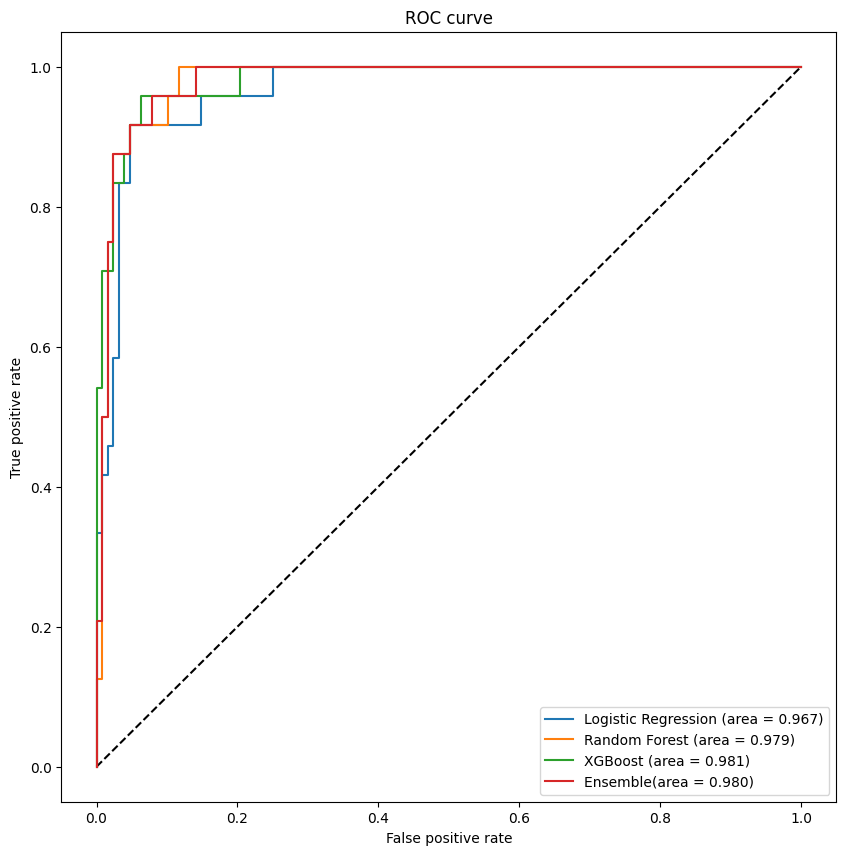

In [72]:
#Now we can draw the ROC curves for all 3 models and the ensemble model.
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#Now we may plot them,
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(*roc_curve(y_test, log_model.predict_proba(nba_filt_test)[:,1])[:2], label="Logistic Regression (area = %0.3f)" % auc(*roc_curve(y_test, log_model.predict_proba(nba_filt_test)[:,1])[:2]))
plt.plot(*roc_curve(y_test, rf_model.predict_proba(nba_filt_test)[:,1])[:2], label="Random Forest (area = %0.3f)" % auc(*roc_curve(y_test, rf_model.predict_proba(nba_filt_test)[:,1])[:2]))
plt.plot(*roc_curve(y_test, xgb_model.predict_proba(nba_filt_test)[:,1])[:2], label="XGBoost (area = %0.3f)" % auc(*roc_curve(y_test, xgb_model.predict_proba(nba_filt_test)[:,1])[:2]))
plt.plot(*roc_curve(y_test, ensemb_clf.predict_proba(nba_filt_test)[:,1])[:2], label="Ensemble(area = %0.3f)" % auc(*roc_curve(y_test, ensemb_clf.predict_proba(nba_filt_test)[:,1])[:2]))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

auc_scores = [auc(*roc_curve(y_test, log_model.predict_proba(nba_filt_test)[:,1])[:2]),
                auc(*roc_curve(y_test, rf_model.predict_proba(nba_filt_test)[:,1])[:2]),
                auc(*roc_curve(y_test, xgb_model.predict_proba(nba_filt_test)[:,1])[:2]),
                auc(*roc_curve(y_test, ensemb_clf.predict_proba(nba_filt_test)[:,1])[:2])]
              
print("Logistic Regression AUC: ", auc_scores[0])
print("Random Forest AUC: ", auc_scores[1])
print("XGBoost AUC: ", auc_scores[2])
print("Ensemble AUC: ", auc_scores[3])

We can also examine what the 2023 predicted All_NBA team looks like versus the actual team.

In [73]:
true_all_nba(nba_filt_test, 2023)

,Player,year,all_nba_tm
509,Joel Embiid,2023,1st
472,Nikola Jokić,2023,2nd
373,Domantas Sabonis,2023,3rd


In [74]:
pred_all_nba_df(nba_filt_test, 2023, ensemb_clf)

,Player,year,prob_all_nba,all_nba_tm,predicted_all_nba_tm
509,Joel Embiid,2023,0.955803,1st,1st
472,Nikola Jokić,2023,0.902115,2nd,2nd
373,Domantas Sabonis,2023,0.769625,3rd,3rd
329,Anthony Davis,2023,0.761162,None,4th


Now we may put all our results into a dataframe

In [75]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#Putting precision and recall and ROC-AUC score into a dataframe for all 4 models
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Ensemble']
precision = [0,0,0,0]
recall = [0,0,0,0]
roc_auc = [0,0,0,0]
f1_scores = [0,0,0,0]
accuracy = [0,0,0,0]
for i, preds in enumerate([log_preds, rf_preds, xgb_preds, ens_preds]):
    precision[i] = precision_score(y_test, preds)
    recall[i] = recall_score(y_test, preds)
    roc_auc[i] = auc_scores[i]
    f1_scores[i] = f1_score(y_test, preds)
    accuracy[i] = accuracy_score(y_test, preds)
res_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F-1 Score':f1_scores ,'ROC-AUC': roc_auc})
res_df.to_csv('res/results_c.csv', index=False)

In [76]:
res_df

,Model,Accuracy,Precision,Recall,F-1 Score,ROC-AUC
0,Logistic Regression,0.947368,0.833333,0.833333,0.833333,0.967448
1,Random Forest,0.973684,0.916667,0.916667,0.916667,0.979167
2,XGBoost,0.973684,0.916667,0.916667,0.916667,0.981120
3,Ensemble,0.973684,0.916667,0.916667,0.916667,0.979818
